###   Importing libraries

In [41]:
from csv import DictReader
from csv import DictWriter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import spacy
import pandas as pd

### Importing Dataset

In [42]:
# Load data
train_bodies = pd.read_csv('test_bodies.csv')
train_stances = pd.read_csv('fnc_testdata_predictions.csv')

In [43]:
train_bodies_copy = train_bodies.copy()
train_bodies_copy.head(5)
train_stances_copy =train_stances.copy()

###  Data Observation

In [15]:
train_bodies_copy.head(10)

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...
5,20,“I once sent Tim an email about the quality of...
6,21,Absolutely no one was devastated when news bro...
7,28,In designing its first wearable device in the ...
8,31,"The picture of a possible ""Crabzilla"" measurin..."
9,33,"Early Tuesday morning, Dornella Conner was “ri..."


In [16]:
train_stances_copy.head(10)

,Headline,Body ID,stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated
5,Next-generation Apple iPhones' features leaked,2353,unrelated
6,Saudi national airline may introduce gender se...,192,unrelated
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated
9,Woman has surgery to get third breast: The thr...,85,unrelated


### Text Preprocessing 

In [17]:
#data observation
import nltk
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
for i in range(0, len(train_bodies)):
    review = re.sub('[^a-zA-Z]', ' ', train_bodies['articleBody'][i])
    review = review.lower()
    review = review.split()
    
    train_bodies_copy['articleBody'][i] = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    train_bodies_copy['articleBody'][i] = ' '.join(train_bodies_copy['articleBody'][i])
for i in range(0, len(train_stances)):
    review = re.sub('[^a-zA-Z]', ' ', train_stances['Headline'][i])
    review = review.lower()
    review = review.split()
    
    train_stances_copy['Headline'][i] = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    train_stances_copy['Headline'][i] = ' '.join(train_stances_copy['Headline'][i])

C:\Users\Justin\AppData\Local\Temp\ipykernel_19208\3329142917.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_bodies_copy['articleBody'][i] = [ps.stem(word) for word in review if not word in stopwords.words('english')]
C:\Users\Justin\AppData\Local\Temp\ipykernel_19208\3329142917.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_bodies_copy['articleBody'][i] = ' '.join(train_bodies_copy['articleBody'][i])


In [91]:
train_bodies_copy.loc[10,]

articleBody    Two Hundred Sikh pilgrims from among 800 who w...
Body ID                                                       61
Name: 10, dtype: object

In [27]:
train_stances_copy.head(10)

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
6,Accused Boston Marathon Bomber Severely Injure...,962,unrelated
7,Identity of ISIS terrorist known as 'Jihadi Jo...,2033,unrelated
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
9,British Aid Worker Confirmed Murdered By ISIS,882,unrelated


In [29]:
train_bodies_copy.head(10)

,Body ID,articleBody
0,0,small meteorit crash wood area nicaragua capit...
1,4,last week hint come ebola fear spread across a...
2,5,newser wonder long quarter pounder chees last ...
3,6,post photo gun tote child onlin isi support an...
4,7,least suspect boko haram insurg kill clash sol...
5,8,much fake stuff internet given week grown tire...
6,9,cnn meteorit crash managua nicaragua late satu...
7,10,move netflix hulu word amazon look launch ad s...
8,11,seen tradit depict god cloud dwell figur flow ...
9,13,soldier shot canada nation war memori wit say ...


### Step 4 

In [92]:
#“Agrees” if
#      i) all named-entities in the headline are present in the body text
#      ii) for each noun, verb, adjective/adverb category of the headline, either the same token occurs in the body 
#             or its synonym word occurs in the body text
#      iii) there is preservation of negation (if negation is present in headline, it should be present in body text,  if headline has no negation, then body text should not contain any negation as well)

In [44]:
from nltk.corpus import brown
from gensim.models import Word2Vec
b = Word2Vec(brown.sents())


In [45]:
sim_list = []
for i in b.wv.most_similar("glass", topn=5):
    sim_list.append(i[0])
print(sim_list)
# print(train_bodies_copy['articleBody'].to_list())

['sheet', 'canvas', 'dirt', 'chill', 'blade']


In [46]:
print(brown.sents())

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]


In [47]:
import spacy
from spacy import displacy
import spacy
from negspacy.negation import Negex
nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("negex", config={"ent_types":[]})

#doc = nlp(text)
#displacy.render(doc, style = "dep")
def check_pos_tag(var_1):
    list_1 = []
    doc = nlp(var_1)
    for token in doc:
        if token.head.pos_ in ['VERB','NOUN','ADJ','ADV']:
            list_1.append(token.text)
    return list_1
    
def named_entity(var_2):
    list_2 = []
    doc = nlp(var_2)
    for ent in doc.ents:
        list_2.append(ent.text)
    return list_2
        
# First take each headings headings and convert that into pos tag in this format (Body ID, Pos of tag)
corpus = []
temp = 0

final_df = []

News_corpus =[ i.split() for i in train_bodies_copy['articleBody']]
b = Word2Vec(News_corpus)
# b.wv.most_similar("glass", topn=5) 
for i in range(0, len(train_stances_copy)):
    temp_bodyID = train_stances_copy['Body ID'][i]
    for j in range (0, len(train_bodies_copy)):
        if temp_bodyID == train_bodies_copy['Body ID'][j]:
            temp = j
            break
    count_name_tag = 0
    count_pos_tag = 0
    name_tag_body_list = []
    pos_tag_body_list = []
    name_tag_body_list = named_entity(train_bodies_copy['articleBody'][temp])
    pos_tag_body_list = check_pos_tag(train_bodies_copy['articleBody'][temp])
    doc = nlp(train_stances_copy['Headline'][i])
    doc_1 = nlp(train_bodies_copy['articleBody'][temp])
    neg_headline_list=[]
    neg_body_list=[]
    similar_list=[]
    
    for k in check_pos_tag(train_stances_copy['Headline'][i]):
        try:
            for index, tup in b.wv.most_similar(k, topn=5):
                similar_list.append(index)
            break
        except:
            pass
        
    pos_tag_body_list = pos_tag_body_list + similar_list
    for e in doc.ents:
        neg_headline_list.append(e.text+" "+ str(e._.negex))
    for e in doc_1.ents:
        neg_body_list.append(e.text+" "+ str(e._.negex))
#     print(neg_headline_list)
#     print(neg_body_list)
#     print(neg_headline_list)
#     print(neg_body_list)
    
#     if (elem in name_tag_body_list for elem in named_entity(train_stances_copy['Headline'][i])):
#         count_name_tag =count_name_tag + 1
#     if (elem in pos_tag_body_list for elem in check_pos_tag(train_stances_copy['Headline'][i])):
#         count_pos_tag = count_pos_tag + 1
        
    for elem in check_pos_tag(train_stances_copy['Headline'][i]):
        if elem in pos_tag_body_list:
            count_pos_tag = count_pos_tag + 1
    for elem in named_entity(train_stances_copy['Headline'][i]):
        if elem in name_tag_body_list:
            count_name_tag =count_name_tag + 1
    
    
    
    if count_pos_tag==0 or count_name_tag==0:
        final_df.append('unrelated')
    else:
        # named entity check
        if len(named_entity(train_stances_copy['Headline'][i]))!=0 and all(elem in name_tag_body_list for elem in named_entity(train_stances_copy['Headline'][i])):
            final_df.append('agree')
        # pos tag and similiarity check
        elif  all(elem in pos_tag_body_list for elem in check_pos_tag(train_stances_copy['Headline'][i])) :  
            final_df.append('agree')
        # negation check
        elif len(neg_headline_list)!=0 and all(elem in neg_body_list for elem in neg_headline_list):
            final_df.append('agree')
        elif count_pos_tag >= 1 and count_name_tag>= 1:
            final_df.append('discuss')
        else:
            for index, tup in enumerate(neg_headline_list):
                for i,j in enumerate(neg_body_list):
                    if index == i:
                        if tup != j:
                            final_df.append('disagree')
final_dataframe = pd.DataFrame (final_df, columns = ['stances'])


In [63]:

NLP_Dataframe = pd.read_csv("fnc_testdata_predictions.csv")

In [64]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_actual =    NLP_Dataframe["stance"]
y_predicted = final_dataframe["stances"]

accuracy = accuracy_score(y_actual, y_predicted)
print(accuracy)


0.6501003423444693


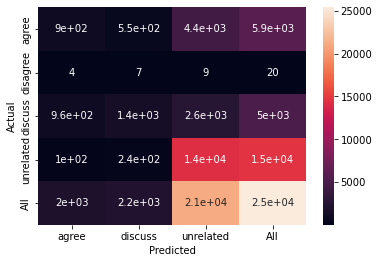

In [65]:
data = {'y_actual':    NLP_Dataframe["stance"],
        'y_predicted': final_dataframe["stances"]
        }
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [188]:
#testing
b.wv.most_similar("Apple", topn=5) 

[('gold', 0.9160498976707458),
 ('Judicial', 0.9082083702087402),
 ('Edition', 0.881341278553009),
 ('price', 0.8807346820831299),
 ('new', 0.876643717288971)]

In [12]:
import spacy 
import stanza 
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset 
nlp_model = spacy_stanza.load_pipeline('en')
nlp_model.add_pipe("negex", config={"ent_types":[]})
sample = nlp_model('There is no English language option.')
 
for e in sample.ents:
  print(e.text, e._.negex)

2022-10-29 15:59:58 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-10-29 16:00:53 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2022-10-29 16:00:53 INFO: Use device: cpu
2022-10-29 16:00:53 INFO: Loading: tokenize
2022-10-29 16:00:53 INFO: Loading: pos
2022-10-29 16:00:54 INFO: Loading: lemma
2022-10-29 16:00:54 INFO: Loading: depparse
2022-10-29 16:00:54 INFO: Loading: sentiment
2022-10-29 16:00:54 INFO: Loading: constituency
2022-10-29 16:00:55 INFO: Loading: ner
2022-10-29 16:00:55 INFO: Done loading processors!


English True


### Task 8


In [27]:
#  for testing the corona data
train_bodies_copy = pd.read_csv('Corona_Bodies.csv', encoding='latin-1')
train_stances_copy = pd.read_csv('Corona_Stances.csv', encoding='latin-1')



In [25]:
import spacy
from spacy import displacy
import spacy
from negspacy.negation import Negex
nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("negex", config={"ent_types":[]})

#doc = nlp(text)
#displacy.render(doc, style = "dep")
def check_pos_tag(var_1):
    list_1 = []
    doc = nlp(var_1)
    for token in doc:
        if token.head.pos_ in ['VERB','NOUN','ADJ','ADV']:
            list_1.append(token.text)
    return list_1
    
def named_entity(var_2):
    list_2 = []
    doc = nlp(var_2)
    for ent in doc.ents:
        list_2.append(ent.text)
    return list_2
        
# First take each headings headings and convert that into pos tag in this format (Body ID, Pos of tag)
corpus = []
temp = 0

final_df = []

News_corpus =[ i.split() for i in train_bodies_copy['articleBody']]
b = Word2Vec(News_corpus)
# b.wv.most_similar("glass", topn=5) 
for i in range(0, len(train_stances_copy)):
    temp_bodyID = train_stances_copy['Body ID'][i]
    for j in range (0, len(train_bodies_copy)):
        if temp_bodyID == train_bodies_copy['Body ID'][j]:
            temp = j
            break
    count_name_tag = 0
    count_pos_tag = 0
    name_tag_body_list = []
    pos_tag_body_list = []
    name_tag_body_list = named_entity(train_bodies_copy['articleBody'][temp])
    pos_tag_body_list = check_pos_tag(train_bodies_copy['articleBody'][temp])
    doc = nlp(train_stances_copy['Headline'][i])
    doc_1 = nlp(train_bodies_copy['articleBody'][temp])
    neg_headline_list=[]
    neg_body_list=[]
    similar_list=[]
    
    for k in check_pos_tag(train_stances_copy['Headline'][i]):
        try:
            for index, tup in b.wv.most_similar(k, topn=5):
                similar_list.append(index)
            break
        except:
            pass
        
    pos_tag_body_list = pos_tag_body_list + similar_list
    for e in doc.ents:
        neg_headline_list.append(e.text+" "+ str(e._.negex))
    for e in doc_1.ents:
        neg_body_list.append(e.text+" "+ str(e._.negex))
        
    for elem in check_pos_tag(train_stances_copy['Headline'][i]):
        if elem in pos_tag_body_list:
            count_pos_tag = count_pos_tag + 1
    for elem in named_entity(train_stances_copy['Headline'][i]):
        if elem in name_tag_body_list:
            count_name_tag =count_name_tag + 1
    
    
    
    if count_pos_tag==0 or count_name_tag==0:
        final_df.append('unrelated')
    else:
        if len(named_entity(train_stances_copy['Headline'][i]))!=0 and all(elem in name_tag_body_list for elem in named_entity(train_stances_copy['Headline'][i])):
            final_df.append('agree')
        elif  all(elem in pos_tag_body_list for elem in check_pos_tag(train_stances_copy['Headline'][i])) :  
            final_df.append('agree')
        elif len(neg_headline_list)!=0 and all(elem in neg_body_list for elem in neg_headline_list):
            final_df.append('agree')
        elif count_pos_tag >= 1 and count_name_tag>= 1:
            final_df.append('discuss')
        else:
            for index, tup in enumerate(neg_headline_list):
                for i,j in enumerate(neg_body_list):
                    if index == i:
                        if tup != j:
                            final_df.append('disagree')
final_dataframe = pd.DataFrame (final_df, columns = ['stances'])
final_dataframe.to_csv('Corona_Test_results_v6.csv', index=False)

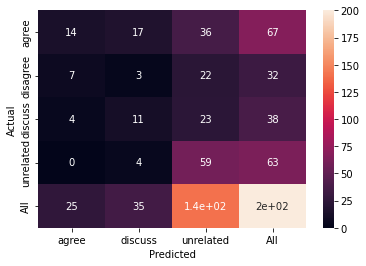

0.42
              precision    recall  f1-score   support

       agree       0.56      0.21      0.30        67
    disagree       0.00      0.00      0.00        32
     discuss       0.31      0.29      0.30        38
   unrelated       0.42      0.94      0.58        63

    accuracy                           0.42       200
   macro avg       0.32      0.36      0.30       200
weighted avg       0.38      0.42      0.34       200



C:\Users\Justin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#corona dataset testing results

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

final_dataframe = pd.read_csv("Corona_Test_results_v6.csv")

y_actual =    train_stances_copy["Stance"]
y_predicted = final_dataframe["stances"]

data = {'y_actual':    train_stances_copy["Stance"],
        'y_predicted': final_dataframe["stances"]
        }
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

accuracy = accuracy_score(y_actual, y_predicted)
print(accuracy)
target_names = ['agree','disagree','discuss','unrelated']
accuracy = accuracy_score(y_actual, y_predicted)
print(classification_report(df['y_actual'],df['y_predicted'],target_names=target_names))

In [38]:
#for testing the economic data
train_bodies_copy = pd.read_csv('Economic_Bodies.csv', encoding='latin-1')
train_stances_copy = pd.read_csv('Economic_Stances.csv', encoding='latin-1')

In [30]:
import spacy
from spacy import displacy
import spacy
from negspacy.negation import Negex
nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("negex", config={"ent_types":[]})

#doc = nlp(text)
#displacy.render(doc, style = "dep")
def check_pos_tag(var_1):
    list_1 = []
    doc = nlp(var_1)
    for token in doc:
        if token.head.pos_ in ['VERB','NOUN','ADJ','ADV']:
            list_1.append(token.text)
    return list_1
    
def named_entity(var_2):
    list_2 = []
    doc = nlp(var_2)
    for ent in doc.ents:
        list_2.append(ent.text)
    return list_2
        
# First take each headings headings and convert that into pos tag in this format (Body ID, Pos of tag)
corpus = []
temp = 0

final_df = []

News_corpus =[ i.split() for i in train_bodies_copy['articleBody']]
b = Word2Vec(News_corpus)
# b.wv.most_similar("glass", topn=5) 
for i in range(0, len(train_stances_copy)):
    temp_bodyID = train_stances_copy['Body ID'][i]
    for j in range (0, len(train_bodies_copy)):
        if temp_bodyID == train_bodies_copy['Body ID'][j]:
            temp = j
            break
    count_name_tag = 0
    count_pos_tag = 0
    name_tag_body_list = []
    pos_tag_body_list = []
    name_tag_body_list = named_entity(train_bodies_copy['articleBody'][temp])
    pos_tag_body_list = check_pos_tag(train_bodies_copy['articleBody'][temp])
    doc = nlp(train_stances_copy['Headline'][i])
    doc_1 = nlp(train_bodies_copy['articleBody'][temp])
    neg_headline_list=[]
    neg_body_list=[]
    similar_list=[]
    
    for k in check_pos_tag(train_stances_copy['Headline'][i]):
        try:
            for index, tup in b.wv.most_similar(k, topn=5):
                similar_list.append(index)
            break
        except:
            pass
        
    pos_tag_body_list = pos_tag_body_list + similar_list
    for e in doc.ents:
        neg_headline_list.append(e.text+" "+ str(e._.negex))
    for e in doc_1.ents:
        neg_body_list.append(e.text+" "+ str(e._.negex))
        
    for elem in check_pos_tag(train_stances_copy['Headline'][i]):
        if elem in pos_tag_body_list:
            count_pos_tag = count_pos_tag + 1
    for elem in named_entity(train_stances_copy['Headline'][i]):
        if elem in name_tag_body_list:
            count_name_tag =count_name_tag + 1
    
    
    
    if count_pos_tag==0 or count_name_tag==0:
        final_df.append('unrelated')
    else:
        if len(named_entity(train_stances_copy['Headline'][i]))!=0 and all(elem in name_tag_body_list for elem in named_entity(train_stances_copy['Headline'][i])):
            final_df.append('agree')
        elif  all(elem in pos_tag_body_list for elem in check_pos_tag(train_stances_copy['Headline'][i])) :  
            final_df.append('agree')
        elif len(neg_headline_list)!=0 and all(elem in neg_body_list for elem in neg_headline_list):
            final_df.append('agree')
        elif count_pos_tag >= 1 and count_name_tag>= 1:
            final_df.append('discuss')
        else:
            for index, tup in enumerate(neg_headline_list):
                for i,j in enumerate(neg_body_list):
                    if index == i:
                        if tup != j:
                            final_df.append('disagree')
final_dataframe = pd.DataFrame (final_df, columns = ['stances'])

In [39]:
# Economic dataset testing results
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_actual =    train_stances_copy["Stance"]
y_predicted = final_dataframe["stances"]

"Accuracy of the corona dataset on the model"

accuracy = accuracy_score(y_actual, y_predicted)
print(accuracy)
matrix = confusion_matrix(y_actual, y_predicted)
matrix.diagonal()/matrix.sum(axis=1)

0.505


array([0.5952381 , 0.        , 0.22      , 0.92857143])

              precision    recall  f1-score   support

       agree       0.57      0.60      0.58        42
    disagree       0.00      0.00      0.00        38
     discuss       0.42      0.22      0.29        50
   unrelated       0.50      0.93      0.65        70

    accuracy                           0.51       200
   macro avg       0.37      0.44      0.38       200
weighted avg       0.40      0.51      0.42       200



C:\Users\Justin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


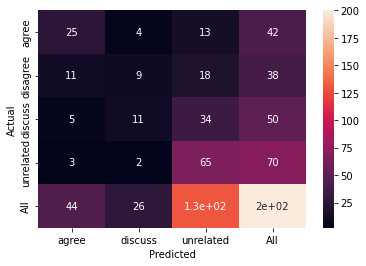

In [40]:
from sklearn.metrics import classification_report
data = {'y_actual':    train_stances_copy["Stance"],
        'y_predicted': final_dataframe["stances"]
        }
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)

sn.heatmap(confusion_matrix, annot=True)
target_names = ['agree','disagree','discuss','unrelated']
print(classification_report(df['y_actual'],df['y_predicted'],target_names=target_names))
plt.show()